In [2]:
%reload_ext autoreload
%autoreload 2
from mt.laser import get_func_gen_settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
on_time = off_time = np.linspace(0.01, 0.1, 100)
passes = np.arange(1, 11)

cycles = 7
time = 0.033 # s
settings_time = [get_func_gen_settings(time, time, cycles, 45, legacy=False) for time in on_time]
settings_passes = [get_func_gen_settings(time, time, p, 45, legacy=False) for p in passes]

setting_time = pd.DataFrame(settings_time)
settings_pass = pd.DataFrame(settings_passes)

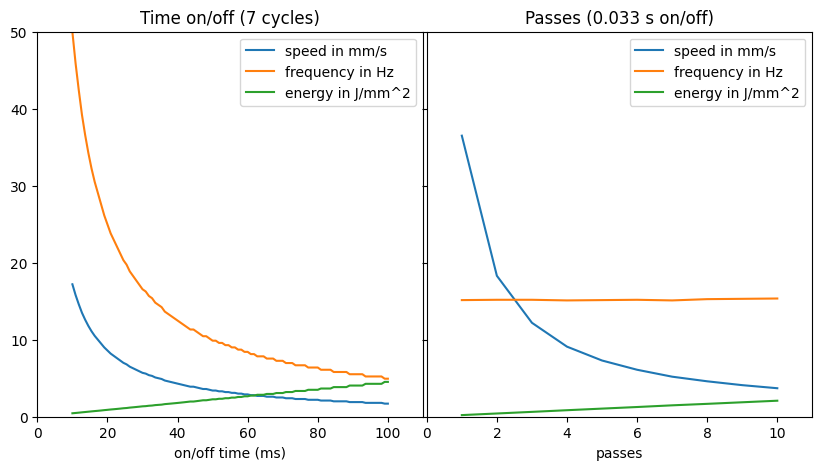

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0.01)
axs[0].plot(on_time*1e3, setting_time["speed"], label="speed in mm/s")
axs[0].plot(on_time*1e3, setting_time["frequency"], label="frequency in Hz")
axs[0].plot(on_time*1e3, setting_time["equivalent_energy"], label="energy in J/mm^2")
axs[0].axis([0, 110, 0, 50])
axs[0].set_xlabel("on/off time (ms)")
axs[0].legend()
axs[0].set_title("Time on/off ({} cycles)".format(cycles))

axs[1].plot(passes, settings_pass["speed"], label="speed in mm/s")
axs[1].plot(passes, settings_pass["frequency"], label="frequency in Hz")
axs[1].plot(passes, settings_pass["equivalent_energy"], label="energy in J/mm^2")
axs[1].axis([0, 11, 0, 50])
axs[1].set_xlabel("passes")
axs[1].legend()
axs[1].set_title("Passes ({} s on/off)".format(time))
plt.show()

Text(0.5, 1.0, 'Equivalent energy in J/mm^2')

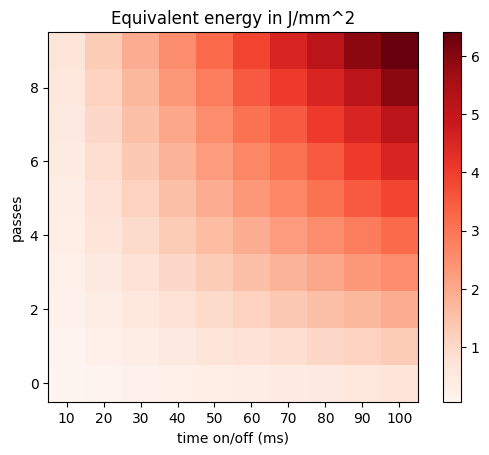

In [5]:
on_time = np.linspace(0.01, 0.1, 10)
passes = np.arange(1, 11)


settings = np.array([[get_func_gen_settings(time, time, p, 45, legacy=False)["equivalent_energy"] for time in on_time] for p in passes])


plt.imshow(settings, cmap="Reds", interpolation="nearest")
plt.colorbar()
plt.xlabel("time on/off (ms)")
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, 10, 1), ["{:.0f}".format(t*1e3) for t in on_time])
plt.ylabel("passes")
plt.grid(False)
plt.title("Equivalent energy in J/mm^2")

Assumptions for the equivalent energy calculation:
- The energy is assumed to be constant over the whole pulse duration.
- The entire laser power is absorbed by the material.
- The entire laser power is concentrated in the focal point of given spot size

Therefore, the equivalent energy is much larger than the actual energy delivered to the material.

In [15]:
on = 0.16 # s
off = 0.08 # s
passes = 10


_ = get_func_gen_settings(on, off, passes, 45, legacy=False, verbose=True)

Settings:
Set on time: 160 ms
Set off time: 80 ms
Cycles: 10
--------------------
Speed: 1.0 mm/s
Frequency: 4.15 Hz
Duty cycle: 67 %
Total time over spot: 2.41 s
Equivalent energy: 10.26 J/mm^2
--------------------
Actual on time: 161 ms
Total on time: 1607 ms
Actual off time: 80 ms
Total off time: 803 ms
